##install and import requird packages


In [1]:
!pip install -q transformers
!pip install -q tensorflow
!pip install -q livelossplot

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
#import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time

from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForTokenClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

#import data directly from google drive

In [3]:
!gdown --id 1L0dMHIk6AUQSeZLj8WDx9B__VM5g5LDN

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L0dMHIk6AUQSeZLj8WDx9B__VM5g5LDN
To: /content/BijankhanCorpus.txt
100% 157M/157M [00:01<00:00, 88.9MB/s]


#data exploration and cleaning

In [4]:
#read the .txt file with pandas
data = pd.read_csv("BijankhanCorpus.txt", sep='\s\s+', header=None, names=['word', 'POS_tag'])

print("shape of dataframe is: ", data.shape, "\n", "----------------------")
data.sample(5)

shape of dataframe is:  (2597937, 2) 
 ----------------------


,word,POS_tag
1336766,با,P
2236107,دوجين,N_SING
133028,بر,P
572021,و,CON
1318415,درخت,N_SING


In [5]:
#check null value in dataframe
data.isnull().sum()

word       0
POS_tag    0
dtype: int64

In [6]:
words=list(set(data['word']))

nu_words=len(words)
print('number of unique words: ', nu_words)

number of unique words:  76977


In [7]:
tags=list(set(data['POS_tag']))

nu_tags=len(tags)
print('number of unique tags: ', nu_tags)

number of unique tags:  40


In [8]:
data['POS_tag'].value_counts()

N_SING      967545
P           319858
DELM        256486
ADJ_SIM     231151
CON         210292
N_PL        160419
V_PA         80594
PRO          61859
V_PRS        51738
DET          45898
V_PRE        42494
V_SUB        33820
ADJ_INO      27195
ADV_NI       21900
V_AUX        15870
QUA          15418
ADV_TIME      8427
ADJ_CMPR      7443
ADJ_SUP       7343
ADJ_ORD       6592
SPEC          3809
AR            3493
ADV_EXM       3191
IF            3122
MORP          3027
ADV_I         2094
ADV_NEGG      1668
ADV           1515
V_IMP         1157
PP             880
MQUA           361
PS             333
OH             283
MS             261
DEFAULT        192
INT            113
NP              52
ADJ             22
OHH             20
NN               2
Name: POS_tag, dtype: int64

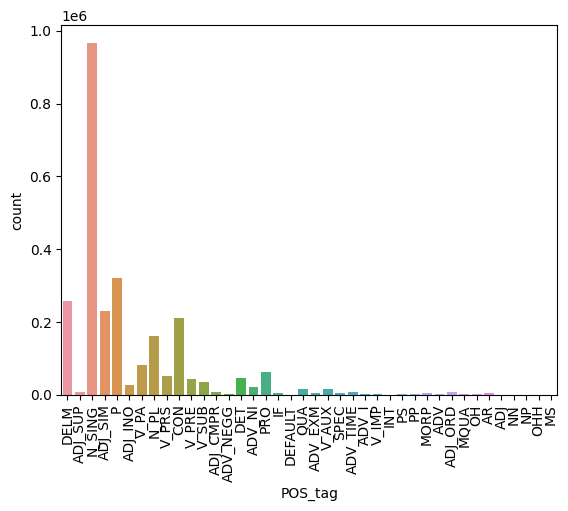

In [9]:
ax = sns.countplot(x='POS_tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [10]:
def create_sequences(data, sentence_delimiters=['.']):

    # Group the data by sentence delimiter
    grouped = data.groupby((data['word'].isin(sentence_delimiters)).cumsum())

    #convert string tag to integer tag
    le_tags = LabelEncoder()
    data.loc[:, 'POS_tag'] = le_tags.fit_transform(data['POS_tag'])

    # Extract the words and tags for each group using a list comprehension
    sentences_list = [group['word'].tolist() for _, group in grouped]
    tags_list = [group['POS_tag'].tolist() for _, group in grouped]

    # Return the list of sentences and list of tags
    return sentences_list, tags_list


In [11]:
sentences_list, tags_list = create_sequences(data)
print(sentences_list[0:1], "\n", tags_list[0:1] )

[['#', 'اولين', 'سياره', 'خارج', 'از', 'منظومه', 'شمسي', 'ديده', 'شد']] 
 [[15, 5, 25, 4, 28, 25, 4, 2, 36]]


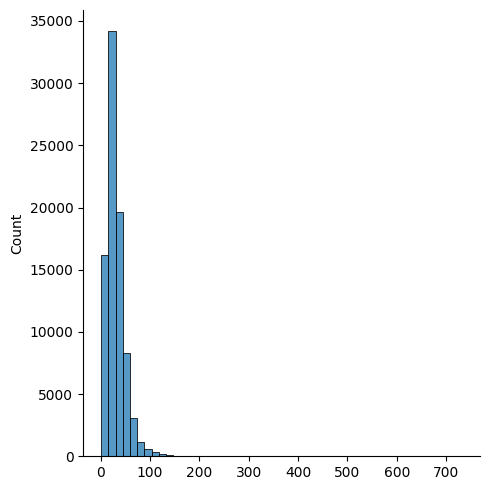

In [12]:
#Word length distribution
sns.displot([len(s) for s in sentences_list], bins=50)
plt.show()

In [13]:
max_len = max([len(s) for s in sentences_list])
min_len = min([len(s) for s in sentences_list])

print ('Max_len:', max_len, '    ***    ', 'min_len:', min_len)

Max_len: 732     ***     min_len: 1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(sentences_list,tags_list, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [15]:
# y_train Padding
train_tag = list()
MAX_LEN = 150

for seq in y_train:
    if len(seq) < MAX_LEN:
        # pad the sequence
        padded_sequence = seq + [15] * (MAX_LEN - len(seq))
        train_tag.append(padded_sequence)
    else:
        # truncate the sequence
        train_tag.append(seq[:MAX_LEN])

# Convert train_tag to a 2D numpy array
train_tag = np.array(train_tag)

# Flatten train_tag to a 1D array
#train_combined_sequences = np.concatenate(train_tag)


In [16]:
# y_val Padding
val_tag = list()
MAX_LEN = 150

for seq in y_val:
    if len(seq) < MAX_LEN:
        # pad the sequence
        padded_sequence = seq + [15] * (MAX_LEN - len(seq))
        val_tag.append(padded_sequence)
    else:
        # truncate the sequence
        val_tag.append(seq[:MAX_LEN])

# Convert val_tag to a 2D numpy array
val_tag = np.array(val_tag)

# Flatten val_tag to a 1D array
#val_combined_sequences = np.concatenate(val_tag)


In [17]:
# y_test Padding
test_tag = list()
MAX_LEN = 150

for seq in y_test:
    if len(seq) < MAX_LEN:
        # pad the sequence
        padded_sequence = seq + [15] * (MAX_LEN - len(seq))
        test_tag.append(padded_sequence)
    else:
        # truncate the sequence
        test_tag.append(seq[:MAX_LEN])

# Convert test_tag to a 2D numpy array
test_tag = np.array(test_tag)

# Flatten test_tag to a 1D array
#test_combined_sequences = np.concatenate(test_tag)


In [18]:
y_train = to_categorical(train_tag, num_classes=nu_tags)
y_val = to_categorical(val_tag, num_classes=nu_tags)
y_test = to_categorical(test_tag, num_classes=nu_tags)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(68042, 150, 40)
(7561, 150, 40)
(8401, 150, 40)


In [19]:
#config

MODEL_NAME_OR_PATH = "HooshvareLab/distilbert-fa-zwnj-base"
MAX_LEN = 150
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = AutoConfig.from_pretrained(MODEL_NAME_OR_PATH)
config.num_labels = nu_tags

def tokenize(data, max_len=MAX_LEN):
    tokenized_data = tokenizer(
        text=data,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,  #because we dont have pair sentence
        return_attention_mask=True,
        is_split_into_words=True,  #This is useful for NER or token classification task
        verbose=True
    )
    return tokenized_data

tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/500 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/426k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [21]:
X_train = tokenize(X_train)
X_test = tokenize(X_test)
X_val = tokenize(X_val)

X_train = {
    'input_ids': np.array(X_train['input_ids']),
    'attention_mask': np.array(X_train['attention_mask'])
}
X_test = {
    'input_ids': np.array(X_test['input_ids']),
    'attention_mask': np.array(X_test['attention_mask'])
}
X_val = {
    'input_ids': np.array(X_val['input_ids']),
    'attention_mask': np.array(X_val['attention_mask'])
}


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(TRAIN_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(TEST_BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(VALID_BATCH_SIZE)

#model bulding and training

In [22]:
def build_model(model_name, config, learning_rate=LEARNING_RATE):
    model = TFAutoModelForTokenClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.CategoricalAccuracy("categorical_accuracy")

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [23]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

tf_model.h5:   0%|          | 0.00/434M [00:00<?, ?B/s]

Some layers from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base were not used when initializing TFDistilBertForTokenClassification: ['vocab_projector', 'activation', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/distilbert-fa-zwnj-base and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [24]:
model.summary()

Model: "tf_distil_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  75177984  
 inLayer)                                                        
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  30760     
                                                                 
Total params: 75208744 (286.90 MB)
Trainable params: 75208744 (286.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


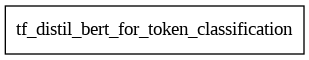

In [25]:
tf.keras.utils.plot_model(model)

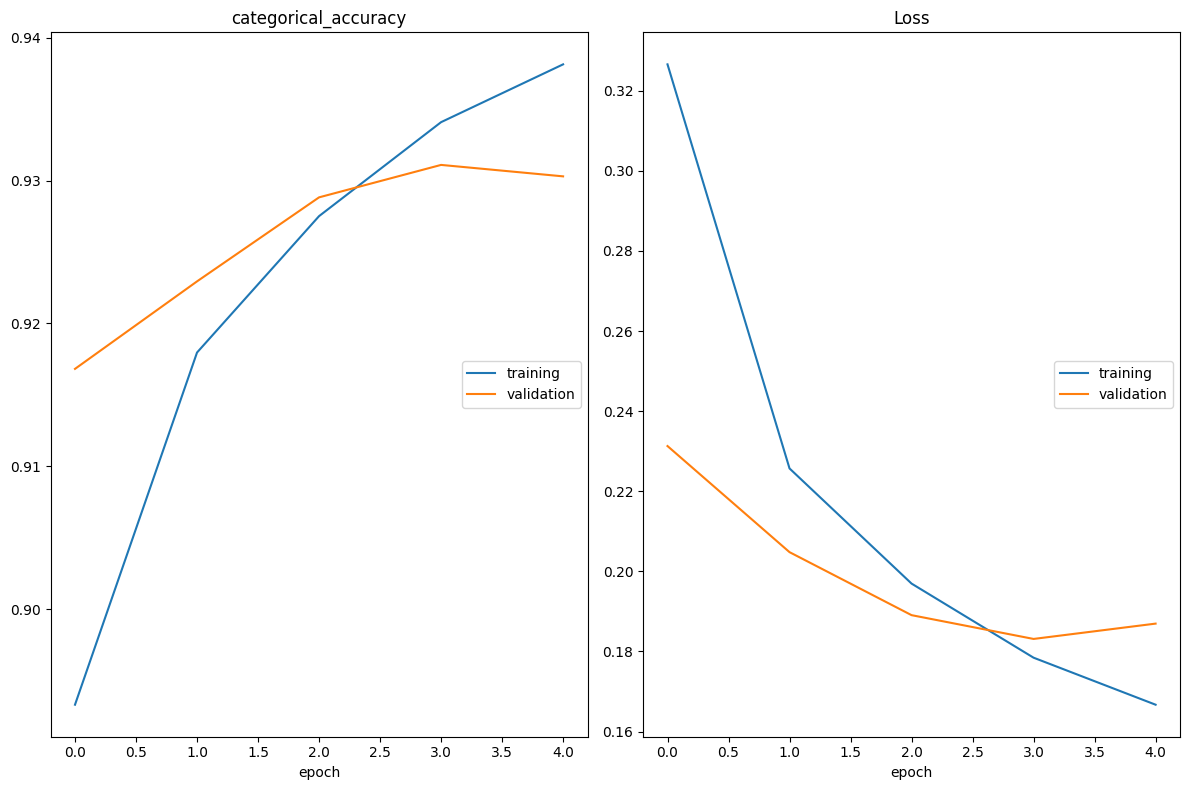

categorical_accuracy
	training         	 (min:    0.893, max:    0.938, cur:    0.938)
	validation       	 (min:    0.917, max:    0.931, cur:    0.930)
Loss
	training         	 (min:    0.167, max:    0.327, cur:    0.167)
	validation       	 (min:    0.183, max:    0.231, cur:    0.187)
4253/4253 [==============================] - 1147s 270ms/step - loss: 0.1667 - categorical_accuracy: 0.9381 - val_loss: 0.1869 - val_categorical_accuracy: 0.9303
Execution time: 5811.01379442215 seconds


In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

#model evaluation

In [27]:
#evaluate model
model.evaluate(X_test, np.array(y_test))

263/263 [==============================] - 45s 171ms/step - loss: 0.1873 - categorical_accuracy: 0.9304


[0.18733246624469757, 0.9304201602935791]

In [28]:
le_tags = LabelEncoder()
data.loc[:, 'POS_tag'] = le_tags.fit_transform(data['POS_tag'])


y_pred_logits = model.predict(X_test)
y_pred = tf.argmax(y_pred_logits.logits, axis=-1)
y_pred_labels = le_tags.inverse_transform(np.array(y_pred).reshape(-1))
y_true_labels = np.array(test_tag).flatten()
#encoded_pred_labels = le_tags.transform(y_pred_labels)

report = classification_report(y_true_labels, y_pred_labels)
print(report)


263/263 [==============================] - 46s 170ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.56      0.53       718
           2       0.51      0.52      0.51      2696
           3       0.58      0.57      0.57       682
           4       0.63      0.53      0.58     22949
           5       0.61      0.70      0.65       710
           6       0.46      0.25      0.32       156
           7       0.47      0.48      0.47       302
           8       0.65      0.48      0.55       181
           9       0.53      0.41      0.46       174
          10       0.48      0.37      0.42      2156
          11       0.59      0.52      0.55       796
          12       0.81      0.64      0.72       275
          13       0.59      0.62      0.60     20748
          14       0.00      0.00      0.00        12
          15       0.99      0.99      0.99   1028584
          16       0.69